# Sistemas dinámicos en dimensiones superiores

La discusión hasta este punto del semestre se puede resumir en la siguiente idea: un sistema unidimensional no es suficiente para modelar la evolución "fisiológica" del potencial de membrana de una neurona. Esto es, si pensamos en el voltaje regulado por una sola ecuación diferencial autónoma (sin corrientes que varían en el tiempo) no podremos describir la aparición de potenciales de acción, ráfagas, mesetas, etc., lo que nos obliga a incorporar variables adicionales de recuperación. 

En el caso fisiológico, los candidatos evidentes son las compuertas de regulación (activación, inactivación) de las distintas corrientes iónicas. Pero, aunque así quisiéramos hacerlo, ¿cómo se hace? ¿Qué repercusiones tiene? ¿De qué manera podemos generar predicciones? Esto tendremos que abordarlo primero desde una perspectiva general sobre la evolución conjunta de dos (o más) variables dinámicas.

<a id='intro'></a>
## Contenido

- [Introducción](#intro)
- [El modelo completo de FitzHugh-Nagumo](#fhn)
- [El modelo INap+IK+IL](#inap)
- [Campos bidimensionales](#2d)
- [Sistemas lineales](#lin)
- [Nodos](#node)
- [Sillas](#saddle)
- [Centros](#center)
- [Focos](#foci)
- [Sistemas lineales más generales](#gen)
- [El modelo de Lotka-Volterra](#lv)
- [El Teorema de Grobman-Hartman](#gh)
- [Modelos bidimensionales varios](#varios)

In [1]:
# Cargamos la paquetería

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.function_base import linspace
from numpy.linalg import norm, eig
from numpy import meshgrid
from numpy.random import randn, uniform, randint

from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.optimize import fsolve
from numpy import sqrt, exp, sin, cos, pi

<a id='fhn'></a>
## El modelo completo FHN

Para motivar esta discusión, empecemos por la reducción geométrica de FitzHugh-Nagumo. Sabemos que la ecuación diferencial

$$\dot{V}=\beta V-\tfrac{V^3}{3}+I$$

es equivalente, en un sentido cualitativo, a cierto modelo basado en conductancias y que, como tal, es incapaz de producir oscilaciones sostenidas. Para resetear el sistema, i.e. alternar entre estados despolarizados e hiperpolarizados, necesitamos una variable de *recuperación* que cumpla la labor de llevar a $V$ cuesta arriba para que ésta cruce el umbral y cambie de cuenca de atracción, y lo mismo una vez más para que regrese a su estado original. Sin mucha justificación, esta nueva variable (a la que llamaremos $w$) sigue la ecuación

$$\dot{w}=\dfrac{1}{\tau}(aV-w-b),$$

donde $\tau>0$ es una *constante de tiempo*. La explicación a grandes rasgos es que $w$ debe ser una copia lenta de $V$, que siga la misma trayectoria general de $V$ pero con un resago dado por la constante $\tau$; entre más grande sea $\tau$, más lenta será la variable $w$ respecto de $V$. Finalmente, incorporamos $w$ en la evolución de $V$ mediante

$$\dot{V}=\beta V-\tfrac{V^3}{3}-w+I.$$

En total, el sistema de FitzHugh-Nagumo está descrito por dos (2) ecuaciobes diferenciales,

$$\begin{align*}
\dot{V}&=\beta V-\tfrac{V^3}{3}-w+I,\\
\dot{w}&=\dfrac{1}{\tau}(aV-w-b),
\end{align*}$$

que se pueden leer como un solo *sistema de ecuaciones diferenciales*.

:o

In [ ]:
### Parámetros

beta = 1.0
I1 = 1.0
a = 0.7
b = 0.8
tau = 12.5

### Campo vectorial

def FHN(u,t):
    V, w = u
    dV = beta*V-V**3/3-w+I1
    dw = 1/tau*(V-b*w+a)
    return [dV,dw]

V0 = -0.5
w0 = 1.0
u0 = [V0,w0]

T = linspace(0,200,20001)

U = odeint(FHN,u0,T)

In [ ]:
V = U[:,0]
w = U[:,1]
p = plt.plot(T,V)
p = plt.title('Traza temporal V FHN')

In [ ]:
p = plt.plot(T,w)
p = plt.title('Traza temporal w FHN')

[Regresar](#intro)

<a id='inap'></a>
## El modelo $I_{Na,p}+I_K$

En el caso de los modelos basados en conductancias, los candidatos evidentes para variables lentas de recuperación son las conductancias, o mejor dicho, las compuertas de regulación. Un modelo sencillo donde es posible implementar esto considera una corriente de sodio y una de potasio,

$$C\dot{V}=I-g_L(V-E_L)-\bar{g}_{Na}m(V-E_{Na})-\bar{g}_Kn(V-E_K),$$

donde $m$ indica la activación de la corriente de sodio, y $n$ indica la activación de la corriente de potasio. Como en el caso unidimensional, consideraremos *instantánea* la activación de sodio,

$$m=m_{\infty}(V),$$

mientras que la activación de potasio será una variable dinámica del sistema, con ecuación diferencial

$$\dot{n}=\dfrac{n_{\infty}(V)-n}{\tau_n(V)},$$

donde $\tau_n(V)$ es la constante de tiempo, similar al caso de FHN, mientras que $n_{\infty}(V)$ es una *función de estado fijo*. Obsérvese que tanto la constante de tiempo como la función de estado fijo son funciones de $V$, y de ahí que las compuertas estén activadas por voltaje. Así como $w$ perseguía a $V$ en el modelo FHN, se puede pensar que el papel de las funciones de estado fijo es marcar la evolución de las variables de activación e inactivación. La función $n_{\infty}$ toma valores entre 0 y 1, y de esta manera se garantiza que $n$ también varíe entre 0 y 1.

En total hemos llegado al sistema de ecuaciones diferenciales

$$\begin{align*}
C\dot{V}&=I-g_L(V-E_L)-\bar{g}_{Na}m(V-E_{Na})-\bar{g}_Kn(V-E_K),\\
\dot{n}&=\dfrac{n_{\infty}(V)-n}{\tau_n(V)}.
\end{align*}$$

In [ ]:
### Capacidad eléctrica

C = 1.0

gNa = 20.0
gL = 8.0
gK = 10.0

### Potenciales de reversión

ENa = 60.0
EL = -80.0
EK = -78.0

### Parámetros de la activación instantánea

def boltz(V,Vh,k):
    return 1/(1+exp((Vh-V)/k))

Vh = 1.5
Del = 16.0
Vm = -38.0
sig = 30.0

### Función de activación instantánea

def minf(V):
    return boltz(V,-20.0,15.0)

def ninf(V):
    return boltz(V,-45.0,5.0)

### Constante de tiempo

def taun(V):
    return 1.0

### Corriente aplicada

I1 = 40.0

### Campo vectorial

def INapL(u,t):
    V, n = u
    dV = (I1-gL*(V-EL)-gNa*minf(V)*(V-ENa)-gK*n*(V-EK))/C
    dn = (ninf(V)-n)/taun(V)
    return [dV,dn]

V0 = 0.0
n0 = ninf(V0)
u0 = [V0,n0]

T = linspace(0,25,2501)

U = odeint(INapL,u0,T)

In [ ]:
V = U[:,0]

p = plt.plot(T,V)
p = plt.title('Traza temporal V INap+IK')

Ya que parece que será un concepto que veremos varias veces, cabe preguntarse: ¿cómo se estudian los *sistemas de ecuaciones diferenciales*?

[Regresar](#intro)

<a id='2d'></a>
## Campos vectoriales (n=2)

$$\dfrac{\mathrm{d}\,\,}{\mathrm{d}t}\left(\begin{array}{c}
x \\
y\end{array}\right)=\left(\begin{array}{c}
f_1(x,y) \\
f_2(x,y)\end{array}\right)$$

Dado que vamos a describir la evolución de dos variables dinámicas a la vez, es necesario pensar en una función que tome dos valores (dos variables de estado, como el potencial de membrana y la variable de recuperación) y que develva otros valores (la derivada de cada entrada). Esta formalización algebraica conlleva varias consecuenicas importantes, en especial en términos geométricos.

En esta ocasión estudiaremos funciones de la forma $f:\mathbb{R}^2\to\mathbb{R}^2$, a las que llamaremos **campos vectoriales bidimensionales**, o simplemente **campos bidimensionales**. Un tal ejemplo sería una función $f(x,y)$ dada por

$$f(x,y)=(2x-y,x+y).$$

Observemos que esta función está "compuesta" de dos funciones, una por cada entrada:

$$\begin{align*}
f_1(x,y)=2x-y,\\
f_2(x,y)=x+y,
\end{align*}$$

$$\begin{align*}
u=2x-y,\\
v=x+y,
\end{align*}$$

$$\left(\begin{array}{c}
u\\
v
\end{array}\right)=\left(\begin{array}{c}
2x-y\\
x+y
\end{array}\right)=\left(\begin{array}{cc}
2 & -1\\
1 & 1
\end{array}\right)\left(\begin{array}{c}
x\\
y
\end{array}\right).$$

$$\left(\begin{array}{c}
u\\
v
\end{array}\right)=A\left(\begin{array}{c}
x\\
y
\end{array}\right).$$

$$A=\left(\begin{array}{cc}
2 & -1\\
1 & 1
\end{array}\right).$$

y que cada una de estas *funciones coordenadas* toman dos valores reales $x$, $y$, y devuelven un valor real. Así podemos hacer evaluaciones de $f$, por ejemplo

$$\begin{align*}
f(0,1)=(-1,1),\\
f(1,-1)=(3,0).
\end{align*}$$

Geométricamente podemos visualizar un campo vectorial bidimensional como un conjunto de flechas dibujadas sobre el plano cartesiano. Si pensamos que esas flechas nos *empujan* por el plano para recorrer trayectorias predeterminadas entonces tendremos un análogo a la interpretación dinámica de las líneas fase para los sistemas unidimensionales. Así, dada una función

$$f:\mathbb{R}^2\to\mathbb{R}^2, \,\, f(x,y)=(f_1(x,y),f_2(x,y)),$$

podemos plantear el **sistema dinámico bidimensional**

$$\begin{align*}
\dot{x}&=f_1(x,y),\\
\dot{y}&=f_2(x,y),
\end{align*}$$

en donde el vector $(x,y)$ es *empujado* por las flechas del campo vectorial $f$. Este sistema contempla dos variables dinámicas, a saber $x=x(t)$, $y=y(t)$ (no hay que olvidar que estamos derivando respecto del tiempo). Entonces cada variable tiene una evolución propia con respecto del tiempo, que podemos graficar como siempre, pero también podemos estudiar la **trayectoria** del vector $(x(t),y(t))$ que dibuja sobre el plano fase. Esto corresponde a la *evolución conjunta del sistema*, que también puede proporcionar información muy útil sobre el estado y el cambio de ambas variables a lo largo del tiempo.

Claramente esta interpretación no es dependiente de que el sistema sea lineal, pero por claridad empezamos con este primer caso que nos permitirá desarrollar cierta teoría predictiva antes de avanzar a los *sistemas no-lineales*.

A diferencia de los campos unidimensionales $f:\mathbb{R}\to\mathbb{R}$, cuya gráfica se puede dibujar en el plano cartesiano $\mathbb{R}^2$, requeriríamos de **cuatro** dimensiones para visualizar el efecto geométrico de un campo bidimensional. Dado que esto es conceptualmente imposible, necesitamos una forma alterna de asimilar la geometría de dichos campos. Afortunadamente podemos hacer una analogía de algo que en su momento fue útil para los campos unidimensionales.

Si pensamos en la *línea fase* de un campo unidimensional como el resultado de dibujar una flecha (la imagen vectorial, con dirección y sentido) sobre cada punto del dominio, entonces podemos hacer lo mismo para un campo bidimensional. Concretamente, dado un elemento $(x,y)\in\mathbb{R}^2$, si llamamos $(u,v)=f(x,y)$, podemos dibujar una flecha que parta del punto $(x,y)$ con dirección $(u,v)$. A esta técnica de visualización le llamaremos el *plano fase*, o más generalmente el *retrato fase*. Esta asignación de flechas está limitada a los puntos con imagen no-cero, $f(x,y)\not=(0,0)$. En caso contrario identificamos a dichos puntos con una notación especial, como una estrella, una cruz, o un punto gordo. Estos puntos tienen la propiedad de *permanecer fijos* bajo acciones del campo vectorial, es decir que **el campo vectorial no los mueve**. Quizás necesitamos un nombre especial para puntos con estas características, pero ésa es una historia para otra ocasión.

In [ ]:
x,y = np.meshgrid(np.linspace(-1, 1, 21), np.linspace(-1, 1, 21))

def f1(x,y):
    u = 2*x-y
    v = x+y
    return [u,v]

u, v = f1(x,y)

z = (x**2+y**2)*np.exp(-x**2 -x**2)
dx, dy = np.gradient(z)
n = -2
color = np.sqrt(((dx-n)/2)*2 + ((dy-n)/2)*2) 

p = plt.figure(figsize=(7,7))
p = plt.title("Ejemplo 1")
p = plt.quiver(x,y,u,v,color)

for k in range(len(x)):
    for m in range(len(y)):
        xk = x[0][k]
        ym = y[m][0]
        u, v = f1(xk,ym)
        
        if norm([u,v])<0.01:
            p = plt.scatter([xk],[ym],marker="x")

[Regresar](#intro)

<a id='lin'></a>
## Sistemas lineales

Para dar una discusión inicial, empezaremos por estudiar los campos bidimensionales *lineales*. Esto es, funciones que se pueden estudiar como

$$f(x,y)=\left(\begin{array}{c}
f_1(x,y)\\
f_2(x,y)
\end{array}\right)=\left(\begin{array}{cc}
a_{11} & a_{12}\\
a_{21} & a_{22}
\end{array}\right)\left(\begin{array}{c}
x\\
y
\end{array}\right),$$

o, equivalentemente, 

$$f(x,y) = A\left(\begin{array}{c}
x \\
y
\end{array}\right),$$

donde $A$ es una matriz $2\times2$. A estas funciones las clasificaremos según su comportamiento en el origen. En lo que sigue, veremos varios ejemplos de comportamientos esencialmente distintos producidos por sistemas lineales, y luego daremos algunas reglas generales para analizar estos sistemas desde una perspectiva matemática.

[Regresar](#intro)

<a id='node'></a>
## Nodos

Consideremos un sistema dado por

$$\begin{align}
\dot{x}&=-\tfrac{1}{2}x,\\
\dot{y}&=-\tfrac{3}{20}y.
\end{align}$$

El campo vectorial en este caso estaría definido por

$$f(x,y)=\left(\begin{array}{c}
-\tfrac{1}{2}x\\
-\tfrac{3}{20}y
\end{array}\right)=\left(\begin{array}{cc}
-\tfrac{1}{2} & 0 \\
0 & -\tfrac{3}{20}
\end{array}\right)\left(\begin{array}{c}
x \\
y
\end{array}\right).
$$

Si dibujamos las flechas dadas por este campo en el plano de fases, notaremos algunas trayectorias con formas familiares

In [ ]:
def f_na(x,y):
    u = -0.5*x
    v = -0.15*y
    return [u,v]

def f_na_int(u,t):
    x, y = u
    dx = f_na(x,y)[0]
    dy = f_na(x,y)[1]
    return [dx,dy]

u, v = f_na(x,y)

z = cos(x**2+y**2)
dx, dy = np.gradient(z)
n = -2
color = np.sqrt(((dx-n)/2)*2 + ((dy-n)/2)*2) 

p = plt.figure(figsize=(7,7))
p = plt.title("Nodo atractor")
p = plt.quiver(x,y,u,v,color,scale=3.0,scale_units='x')

for k in range(len(x)):
    for m in range(len(y)):
        xk = x[0][k]
        ym = y[m][0]
        u, v = f_na(xk,ym)
        
        if norm([u,v])<0.01:
            p = plt.scatter([xk],[ym],marker="x")
            
x0 = -1.0
y0 = 1.0

# Otra condición inicial

# x0 = -1.0
# y0 = -1.0

u0 = [x0,y0]

t = linspace(0,8*np.pi,601)
I = linspace(0,len(t),15)

U = odeint(f_na_int,u0,t)
X = U[:,0]
Y = U[:,1]

p = plt.plot(X,Y,c='magenta')

for k in range(len(I)-1):
    i = int(I[k])
    Xt = X[i]
    Yt = Y[i]
    ut, vt = f_na(Xt,Yt)
    if norm([ut,vt])>0.01:
        p = plt.quiver([Xt],[Yt],[ut],[vt],color='red',scale_units='x',scale=2.0)

p = plt.xlim([-1,1])
p = plt.ylim([-1,1])

Las trayectorias en este caso dibujan parábolas (más específicamente, ramas de parábolas) que se acercan al origen. Es importante mencionar que no todas las trayectorias son estrictamente parabólicas; esto se puede observar sobre los ejes cartesianos. En este caso diremos que el origen del sistema es un **nodo**.

Una figura similar se obtiene en el sistema

$$\begin{align}
\dot{x}&=\tfrac{3}{20}x,\\
\dot{y}&=\tfrac{1}{2}y.
\end{align},$$

donde la matriz asociada al sistema lineal es

$$A=\left(\begin{array}{cc}
\tfrac{3}{20} & 0\\
0 & \tfrac{1}{2}
\end{array}\right).$$

Las trayectorias son nuevamente parabólicas, pero con una diferencia importante. ¿Cuál es?

In [ ]:
def f_nr(x,y):
    u = 0.15*x
    v = 0.5*y
    return [u,v]

def f_nr_int(u,t):
    x, y = u
    dx = f_nr(x,y)[0]
    dy = f_nr(x,y)[1]
    return [dx,dy]

u, v = f_nr(x,y)

z = x**2+x*y+y**2
dx, dy = np.gradient(z)
n = -2
color = np.sqrt(((dx-n)/2)*2 + ((dy-n)/2)*2) 

p = plt.figure(figsize=(7,7))
p = plt.title("Nodo repulsor")
p = plt.quiver(x,y,u,v,color,scale=3.0,scale_units='x')

for k in range(len(x)):
    for m in range(len(y)):
        xk = x[0][k]
        ym = y[m][0]
        u, v = f_nr(xk,ym)
        
        if norm([u,v])<0.01:
            p = plt.scatter([xk],[ym],marker="x")
            
x0 = 0.01
y0 = -0.000005
u0 = [x0,y0]

# Otra condición inicial

# x0 = -0.01
# y0 = -0.000005

t = linspace(0,8*np.pi,601)
I = linspace(0,len(t),15)

U = odeint(f_nr_int,u0,t)
X = U[:,0]
Y = U[:,1]

p = plt.plot(X,Y,c='magenta')

for k in range(len(I)-1):
    i = int(I[k])
    Xt = X[i]
    Yt = Y[i]
    ut, vt = f_nr(Xt,Yt)
    if norm([ut,vt])>0.01:
        p = plt.quiver([Xt],[Yt],[ut],[vt],color='red',scale_units='x',scale=2.0)
        
p = plt.xlim([-1,1])
p = plt.ylim([-1,1])

Notamos que en el primer caso vemos cómo las parábolas se *acercan* al origen, mientras que en el segundo caso se *alejan*. Esto es, las trayectorias tienen un recorrido que pueden acercarnos o alejarnos del origen. Podemos notar esta diferencia en las *trazas tamporales*, esto es, al graficar la evolución de cada variable con respecto del tiempo.

In [ ]:
t = linspace(0,8*np.pi,601)

u0 = [-1,1]

U = odeint(f_na_int,u0,t)
X = U[:,0]
Y = U[:,1]

# Trazas temporales

plt.figure(figsize=(14,6))
plt.plot(t,X,label='x(t)')
plt.plot(t,Y,label='y(t)')
plt.title('Trazas temporales: Nodo atractor')
plt.ylim([-2,2])
plt.xlim([0,12])
# plt.ylim([-1000,1000])
# plt.xlim([0,20])
plt.legend()

In [ ]:
t = linspace(0,30,601)

x0 = 0.01
y0 = -0.000005
u0 = [x0,y0]

U = odeint(f_nr_int,u0,t)
X = U[:,0]
Y = U[:,1]

# Trazas temporales

plt.figure(figsize=(14,6))
plt.plot(t,X,label='x(t)')
plt.plot(t,Y,label='y(t)')
plt.title('Trazas temporales: Nodo repulsor')
plt.ylim([-2,2])
plt.xlim([0,30])
# plt.ylim([-1000,1000])
# plt.xlim([0,20])
plt.legend()

Según vemos, las curvas individuales pueden acercarse o alejarse del origen (independientemente del signo, o de si lo hacen creciendo o decreciendo), pero en ambos casos el comportamiento es el mismo para ambas variables, i.e. ambas se acercan o ambas se alejan. Para diferenciar estos dos sistemas, diremos que en el primero el origen es un **nodo atractor**, mientras que en el segundo es un **nodo repulsor**.

[Regresar](#intro)

<a id='saddle'></a>
## Sillas

Este tipo de comportamiento tiene dos características distintivas: la forma de las trayectorias es hiperbólica (de manera general), y la existencia de dos direcciones donde el origen es puramente atractor y puramente repulsor. Esto es, existen soluciones que convergen en *tiempo positivo* al origen, y soluciones que convergen en *tiempo negativo* (que provienen del origen) y se alejan cada vez más. El sistema que veremos en esta ocasión toma la forma

$$\begin{align}
\dot{x}&=-\tfrac{1}{2}x,\\
\dot{y}&=\tfrac{1}{2}y.
\end{align}$$

La matriz asociada está dada por

$$A=\left(\begin{array}{cc}
-\tfrac{1}{2} & 0\\
0 & \tfrac{1}{2}
\end{array}\right).$$

En lo que sigue, podemos jugar un poco con las condiciones iniciales para encontrar las soluciones antes mencionadas.

In [ ]:
def f_sa(x,y):
    u = -0.5*x
    v = 0.5*y
    return [u,v]

def f_sa_int(u,t):
    x, y = u
    dx = f_sa(x,y)[0]
    dy = f_sa(x,y)[1]
    return [dx,dy]

u, v = f_sa(x,y)

z = sin(x*y)
dx, dy = np.gradient(z)
n = -2
color = np.sqrt(((dx-n)/2)*2 + ((dy-n)/2)*2) 

p = plt.figure(figsize=(7,7))
p = plt.title("Silla")
p = plt.quiver(x,y,u,v,color,scale=7.0,scale_units='x')

for k in range(len(x)):
    for m in range(len(y)):
        xk = x[0][k]
        ym = y[m][0]
        u, v = f_sa(xk,ym)
        
        if norm([u,v])<0.01:
            p = plt.scatter([xk],[ym],marker="x")
            
x0 = -1.0
y0 = -0.01

# Otra condición inicial

# x0 = 1.0
# y0 = -0.01

# Otra otra condición inicial

# x0 = 1.0
# y0 = 0.0

u0 = [x0,y0]

t = linspace(0,4*np.pi,601)
I = linspace(0,len(t),15)

U = odeint(f_sa_int,u0,t)
X = U[:,0]
Y = U[:,1]

p = plt.plot(X,Y,c='magenta')

for k in range(len(I)-1):
    i = int(I[k])
    Xt = X[i]
    Yt = Y[i]
    ut, vt = f_sa(Xt,Yt)
    if norm([ut,vt])>0.01:
        p = plt.quiver([Xt],[Yt],[ut],[vt],color='red',scale_units='x',scale=2.0)
        
p = plt.xlim([-1,1])
p = plt.ylim([-1,1])
p = plt.xlabel('X')
p = plt.ylabel('Y')

Intituivimanete, podemos predecir que cada variable se mantiene con una sola monotonía: o bien crecen, o bien decrecen (o se hacen constantes), pero regularmente una variable diverge a $\pm\infty$ mientras la otra converge a cero.

In [ ]:
t = linspace(0,8*np.pi,601)
I = linspace(0,len(t),15)

# x0 = -1.0
# y0 = -0.01

# Otra condición inicial

# x0 = -1.0
# y0 = 0.01

# Otra otra condición inicial

x0 = 1.0
y0 = 0.0

u0 = [x0,y0]

U = odeint(f_sa_int,u0,t)
X = U[:,0]
Y = U[:,1]

# Trazas temporales

plt.figure(figsize=(14,6))
plt.plot(t,X,label='x(t)')
plt.plot(t,Y,label='y(t)')
plt.title('Trazas temporales: Silla')
plt.ylim([-5,5])
plt.xlim([0,12])
plt.legend()
p = plt.xlabel('t')
p = plt.ylabel('X,Y')

Los sistemas lineales con nodos o sillas se caracterizan por estar asociados a ecuaciones *desacopladas*. Esto quiere decir que podríamos encontrar la solución analítica del sistema, por ejemplo $(x(t),y(t))=(k_1e^{-0.5t},k_2e^{0.5t})$ en el caso de la silla. Sin embargo, entender la geometría de una curva en el plano a través de si definción analítica en ocasiones no es muy sencillo. Vale la pena, sin embargo, notar que seguimos observando términos exponenciales en nuestras soluciones, similares a lo que encontramos en los casos unidimensionales más sencillos. 

[Regresar](#intro)

<a id='center'></a>
## Centros

Cuando las derivadas de cada variable empiezan a depender de las otras, i.e. cuando el sistema está *acoplado*, podemos obtener una gran variedad de comportamientos geométricos. Un tal ejemplo es

$$\begin{align}
\dot{x}&=-\tfrac{1}{2}y,\\
\dot{y}&=\tfrac{1}{2}x,
\end{align}$$

con matriz asociada

$$A=\left(\begin{array}{cc}
0 & -\tfrac{1}{2}\\
\tfrac{1}{2} & 0
\end{array}\right),$$

que dibuja trayectorias circulares (en general, elípticas) en el plano de fases. Para este tipo de sistemas, diremos que el equilibrio es un **centro**.

In [ ]:
# Conjunto de puntos que conforman el plano fase

x,y = meshgrid(linspace(-2, 2, 41), linspace(-2, 2, 41))

# Campo vectorial

def f_centro(x,y):
    u = -0.5*y
    v = 0.5*x
    return [u,v]

# Campo para la integración numérca

def f_centro_int(u,t):
    x, y = u
    dx = f_centro(x,y)[0]
    dy = f_centro(x,y)[1]
    return [dx,dy]

# Direcciones del campo vectorial

u, v = f_centro(x,y)

# Esto dará color a las flechas

z = (x**2+y**2)*np.exp(-x**2 -x**2)
dx, dy = np.gradient(z)
n = -2
color = np.sqrt(((dx-n)/2)*2 + ((dy-n)/2)*2) 

p = plt.figure(figsize=(7,7))
p = plt.title("Centro")
p = plt.quiver(x,y,u,v,color,scale=9.5)

# Ubicamos por nuestra cuenta los puntos sin dirección, es decir donde u=0, v=0

for k in range(len(x)):
    for m in range(len(y)):
        xk = x[0][k]
        ym = y[m][0]
        u, v = f_centro(xk,ym)
        
        if norm([u,v])<0.01:
            p = plt.scatter([xk],[ym],marker="x")
      
# Condición inicial

x0 = 0.5
y0 = 0.0
u0 = [x0,y0]

# Vector de tiempos

t = linspace(0,4*np.pi,601)

# Vector de índices para dibujar flechas sobre las trayectorias

I = linspace(0,len(t),15)

# Integración numérica; extracción de cada variable

U = odeint(f_centro_int,u0,t)
X = U[:,0]
Y = U[:,1]

# Trazo de la trayectoria o evolución conjunta

p = plt.plot(X,Y,c='magenta')

# Flechas sobre las trayectorias

for k in range(len(I)-1):
    i = int(I[k])
    Xt = X[i]
    Yt = Y[i]
    ut, vt = f_centro(Xt,Yt)
    if norm([ut,vt])>0.01:
        p = plt.quiver([Xt],[Yt],[ut],[vt],color='red',scale_units='x',scale=2.0)
        
p = plt.xlim([-1,1])
p = plt.ylim([-1,1])
p = plt.xlabel('X')
p = plt.ylabel('Y')

Podemos intuir que las trazas temporales dibujarán curvas sinusoidales (periódicas) para cada variable.

In [ ]:
# Vector de tiempos

t = linspace(0,8*np.pi,601)

# Condiciones iniciales

x0 = 0.0
y0 = 0.5
u0 = [x0,y0]

# Integración numérica

U = odeint(f_centro_int,u0,t)
X = U[:,0]
Y = U[:,1]

# Trazas temporales

plt.figure(figsize=(12,6))
plt.plot(t,X,label='x(t)')
plt.plot(t,Y,label='y(t)')
plt.title('Trazas temporales: Centro')
plt.legend()
p = plt.xlabel('t')
p = plt.ylabel('X,Y')

A diferencia de los sistemas que dibujan parábolas o hipérbolas, no encontraremos exponenciales (en un sentido real) el las soluciones asociadas a un centro. De manera general, estas soluciones se comportan como combinaciones lineales de $\sin$ y $\cos$. Por ejemplo, en la figura anterior tenemos $(x(t),y(t))=(0.5\cos(t),0.5\sin(t))$.

[Regresar](#intro)

<a id='foci'></a>
## Focos

Los comportamientos tipo-foco se caracterizan por trayectorias dibujadas como espirales que se acercan o se alejan del origen. Un tal ejemplo sería

$$\begin{align}
\dot{x}&=-\tfrac{1}{2}x+\tfrac{1}{4}y,\\
\dot{y}&=-\tfrac{1}{4}x-\tfrac{1}{2}y,
\end{align}$$

con matriz asociada

$$A=\left(\begin{array}{cc}
-\tfrac{1}{2} & \tfrac{1}{4}\\
-\tfrac{1}{4} & -\tfrac{1}{2}
\end{array}\right).$$

Los focos son análogos a los nodos en tanto que notaremos convergencia o divergencia del origen. La siguiente figura presenta un **foco atractor**, donde las trayectorias espirales se acercan al origen.

In [ ]:
def f_fa(x,y):
    u = -0.5*x+0.25*y
    v = -0.25*x-0.5*y
    return [u,v]

def f_fa_int(u,t):
    x, y = u
    dx = f_fa(x,y)[0]
    dy = f_fa(x,y)[1]
    return [dx,dy]

u, v = f_fa(x,y)

z = x**2+y**2+1
dx, dy = np.gradient(z)
n = -2
color = np.sqrt(((dx-n)/2)*2 + ((dy-n)/2)*2) 

p = plt.figure(figsize=(7,7))
p = plt.title("Foco atractor")
p = plt.quiver(x,y,u,v,color,scale=6.0,scale_units='x')

for k in range(len(x)):
    for m in range(len(y)):
        xk = x[0][k]
        ym = y[m][0]
        u, v = f_fa(xk,ym)
        
        if norm([u,v])<0.01:
            p = plt.scatter([xk],[ym],marker="x")
            
x0 = 1.0
y0 = -1.0

# Otra condición inicial

# x0 = 1.0
# y0 = 1.0

u0 = [x0,y0]

t = linspace(0,4*np.pi,601)
I = linspace(0,len(t),15)

U = odeint(f_fa_int,u0,t)
X = U[:,0]
Y = U[:,1]

p = plt.plot(X,Y,c='magenta')

for k in range(len(I)-1):
    i = int(I[k])
    Xt = X[i]
    Yt = Y[i]
    ut, vt = f_fa(Xt,Yt)
    if norm([ut,vt])>0.01:
        p = plt.quiver([Xt],[Yt],[ut],[vt],color='red',scale_units='x',scale=2.0)
        
p = plt.xlim([-1,1])
p = plt.ylim([-1,1])
p = plt.xlabel('X')
p = plt.ylabel('Y')

Las trazas temporales mostrarán oscilaciones amortiguadas a lo largo del tiempo. En general es difícil determinar estas convergencias dada la velocidad exponencial con la que las trayectorias se acercan al origen.

In [ ]:
t = linspace(0,8*np.pi,601)

x0 = -0.5
y0 = 0.2
u0 = [x0,y0]

U = odeint(f_fa_int,u0,t)
X = U[:,0]
Y = U[:,1]

# Trazas temporales

plt.figure(figsize=(12,6))
plt.plot(t,X,label='x(t)')
plt.plot(t,Y,label='y(t)')
plt.title('Trazas temporales: Foco atractor')
plt.ylim([-0.0002,0.0002])
plt.xlim([15,25])
plt.legend()
p = plt.xlabel('t')
p = plt.ylabel('X,Y')

Similar a su versión atractora, el **foco repulsor** presenta trayectorias espirales solo que ahora se alejan del origen. Tenemos entonces las ecuaciones

$$\begin{align}
\dot{x}&=\tfrac{1}{2}x+\tfrac{1}{4}y,\\
\dot{y}&=-\tfrac{1}{4}x+\tfrac{1}{2}y.
\end{align}$$

La matriz asociada se obtiene directamente como

$$A=\left(\begin{array}{cc}
\tfrac{1}{2} & \tfrac{1}{4} \\
-\tfrac{1}{4} & \tfrac{1}{2}
\end{array}\right).$$

Como con la silla y el nodo repulsor, para este sistema hay que cuidar el tiempo de integración ya que la divergencia de soluciones se da con velocidad exponencial, lo que puede ocasionar imágenes donde la evolución inicial (o transitoria) no se aprecie bien.

In [ ]:
def f_fr(x,y):
    u = 0.5*x+0.25*y
    v = -0.25*x+0.5*y
    return [u,v]

def f_fr_int(u,t):
    x, y = u
    dx = f_fr(x,y)[0]
    dy = f_fr(x,y)[1]
    return [dx,dy]


u, v = f_fr(x,y)

z = x*(x**2+y**2+1)
dx, dy = np.gradient(z)
n = -2
color = np.sqrt(((dx-n)/2)*2 + ((dy-n)/2)*2) 

p = plt.figure(figsize=(7,7))
p = plt.title("Foco repulsor")
p = plt.quiver(x,y,u,v,color,scale=7.0,scale_units='x')

for k in range(len(x)):
    for m in range(len(y)):
        xk = x[0][k]
        ym = y[m][0]
        u, v = f_fr(xk,ym)
        
        if norm([u,v])<0.01:
            p = plt.scatter([xk],[ym],marker="x")
            
x0 = -0.01
y0 = -0.001

# Otra condición inicial

x0 = -0.001
y0 = 0.01

u0 = [x0,y0]


t = linspace(0,4*np.pi,601)
I = linspace(0,len(t),15)

U = odeint(f_fr_int,u0,t)
X = U[:,0]
Y = U[:,1]

p = plt.plot(X,Y,c='magenta')

for k in range(len(I)-1):
    i = int(I[k])
    Xt = X[i]
    Yt = Y[i]
    ut, vt = f_fr(Xt,Yt)
    if norm([ut,vt])>0.01:
        p = plt.quiver([Xt],[Yt],[ut],[vt],color='red',scale_units='x',scale=2.0)
        
p = plt.xlim([-1,1])
p = plt.ylim([-1,1])
p = plt.xlabel('X')
p = plt.ylabel('Y')

Las trazas temporales vuelven a ser oscilatorias, pero ahora con amplitudes crecientes.

In [ ]:
t = linspace(0,10*np.pi,601)

x0 = -0.5
y0 = 0.2
u0 = [x0,y0]

U = odeint(f_fr_int,u0,t)
X = U[:,0]
Y = U[:,1]

# Trazas temporales

plt.figure(figsize=(14,6))
plt.plot(t,X,label='x(t)')
plt.plot(t,Y,label='y(t)')
plt.title('Trazas temporales: Foco repulsor')
# plt.ylim([-100,100])
# plt.xlim([0,15])
plt.ylim([-1000,1000])
plt.xlim([0,32])
plt.legend()
p = plt.xlabel('t')
p = plt.ylabel('X,Y')

[Regresar](#intro)

<a id='gen'></a>
## Ejemplos más generales de sistemas lineales

Tomemos el sistema

$$\begin{align}
\dot{x}&=2x-y,\\
\dot{y}&=x+y.
\end{align},$$

con matriz asociada

$$A=\left(\begin{array}{cc}
2 & -1\\
1 & 1
\end{array}\right).$$

Aunque este sistema no es inmediatamente idéntico a los anteriores, podemos dibujar su plano de fases para clasificarlo.

(Sin embargo, los planos de fases son difíciles de hacer a mano. **¿Tenemos alguna alternativa a falta de computadora?**)

In [ ]:
x,y = meshgrid(linspace(-2, 2, 41), linspace(-2, 2, 41))

def f1(x,y):
    u = 2*x-y
    v = x+y
    return [u,v]

def f1_int(u,t):
    x, y = u
    dx = f1(x,y)[0]
    dy = f1(x,y)[1]
    return [dx,dy]

u, v = f1(x,y)

z = (x**2+y**2)*np.exp(-x**2 -x**2)
dx, dy = np.gradient(z)
n = -2
color = np.sqrt(((dx-n)/2)*2 + ((dy-n)/2)*2) 

p = plt.figure(figsize=(7,7))
p = plt.title("Ejemplo 1: Plano fase")
p = plt.quiver(x,y,u,v,color, scale=30.0)

for k in range(len(x)):
    for m in range(len(y)):
        xk = x[0][k]
        ym = y[m][0]
        u, v = f1(xk,ym)
        
        if norm([u,v])<0.01:
            p = plt.scatter([xk],[ym],marker="x")
            
            
x0 = 0.000005
y0 = -0.000005
u0 = [x0,y0]

t = linspace(0,3*np.pi,601)
I = linspace(0,len(t),15)

U = odeint(f1_int,u0,t)
X = U[:,0]
Y = U[:,1]

p = plt.plot(X,Y,c='magenta')

for k in range(len(I)-1):
    i = int(I[k])
    Xt = X[i]
    Yt = Y[i]
    ut, vt = f1(Xt,Yt)
    if norm([ut,vt])>0.01:
        p = plt.quiver([Xt],[Yt],[ut],[vt],color='red',scale_units='x',scale=2.0)

x0 = -0.000005
y0 = -0.000005
u0 = [x0,y0]

U = odeint(f1_int,u0,t)
X = U[:,0]
Y = U[:,1]

p = plt.plot(X,Y,c='magenta')

for k in range(len(I)-1):
    i = int(I[k])
    Xt = X[i]
    Yt = Y[i]
    ut, vt = f1(Xt,Yt)
    if norm([ut,vt])>0.01:
        p = plt.quiver([Xt],[Yt],[ut],[vt],color='red',scale_units='x',scale=2.0)

x0 = 0.000005
y0 = 0.000005
u0 = [x0,y0]

U = odeint(f1_int,u0,t)
X = U[:,0]
Y = U[:,1]

p = plt.plot(X,Y,c='magenta')

for k in range(len(I)-1):
    i = int(I[k])
    Xt = X[i]
    Yt = Y[i]
    ut, vt = f1(Xt,Yt)
    if norm([ut,vt])>0.01:
        p = plt.quiver([Xt],[Yt],[ut],[vt],color='red',scale_units='x',scale=2.0)

x0 = -0.000005
y0 = 0.000005
u0 = [x0,y0]

U = odeint(f1_int,u0,t)
X = U[:,0]
Y = U[:,1]

p = plt.plot(X,Y,c='magenta')

for k in range(len(I)-1):
    i = int(I[k])
    Xt = X[i]
    Yt = Y[i]
    ut, vt = f1(Xt,Yt)
    if norm([ut,vt])>0.01:
        p = plt.quiver([Xt],[Yt],[ut],[vt],color='red',scale_units='x',scale=2.0)

        
p = plt.xlim([-1,1])
p = plt.ylim([-1,1])
p = plt.xlabel('X')
p = plt.ylabel('Y')

Consideremos el sistema

$$\begin{align}
\dot{x} &= -3x+5y, \\
\dot{y} &= -5x+3y.
\end{align}$$

In [ ]:
### Campo vectorial

def f(x, y):
    dx = -3*x+5*y
    dy = -5*x+3*y
    return [dx, dy]

def f_field(x, y):
    dx = -0.3*x+0.5*y
    dy = -0.5*x+0.3*y
    return [dx, dy]

### Campo normalizado (para graficar las flechas)

def f_unit(x, y):
    u, v = f(x, y)
    n = norm([u,v]) 
    if n>0:
        return [u/n, v/n]
    else:
        return [0,0]

### Campo para la integración numérica
    
def f_int(u,t):
    x, y = u
    return f(x, y)

# Conjunto de puntos que conforman el plano fase

x,y = meshgrid(linspace(-1, 1, 21), linspace(-1, 1, 21))

# Campo vectorial

# Direcciones del campo vectorial

u, v = f_field(x,y)

# Esto dará color a las flechas

z = (x**2+y**2)*np.exp(-x**2 -x**2)
dx, dy = np.gradient(z)
n = -2
color = np.sqrt(((dx-n)/2)*2 + ((dy-n)/2)*2) 

p = plt.figure(figsize=(7,7))
p = plt.title("Centro")
p = plt.quiver(x,y,u,v,color,scale=9.5)


### Condiciones iniciales

x0 = 0.0
y0 = 0.8
u0 = [x0, y0]

### Tiempo de integración
# Los osciladores tienen frecuencia w=4, así que tardan 2pi/4 en completar una vuelta

t = linspace(0,0.45*pi,201)

### Integración numérica

U = odeint(f_int,u0,t)
X = U[:,0]
Y = U[:,1]

### Graficación 
# Curvas, vectores del cambio de base, condición inicial

p = plt.plot(X,Y, label='Trayectoria numérica')
p = plt.scatter([x0],[y0],c='red',label='Condición inicial')
p = plt.plot([0,0],[0,0.8],c='black')
p = plt.plot([0,1],[0,0.6],c='black')

# Flechas para verificar la dirección de recorrido

I = linspace(0,len(t)-1,21)

for k in range(len(I)):
    it = int(I[k])
    xt = X[it]
    yt = Y[it]
    u, v = f_unit(xt,yt)
    if norm([u,v])>0:
        p = plt.quiver(xt,yt,u,v,color='magenta')

p = plt.legend()
p = plt.xlabel('X')
p = plt.ylabel('Y')

[Regresar](#intro)

<a id='lv'></a>
## El modelo de Lotka-Volterra

Cuando el campo vectorial es no-lineal, los comportamientos pueden ser considerablemente distintos, incrementando el número de puntos de equilibrio, y "combinando" uno o varios de los planos de fase anteriores, dando pie a nuevos fenómenos dinámicos. Antes de pasar a lo modelos principales en Neurociencias, motivaremos ciertos conceptos dinámicos en un sistema ecológico. El **modelo de Lotka-Volterra** describe la evolución de una población de presas $P(t)$ y una de depredadores $D(t)$. Las ecuaciones están dadas por

$$\begin{align}
\dot{P}&=\alpha P-\beta DP,\\
\dot{D}&=\gamma DP-\delta D,
\end{align}$$

donde $P$ es la cantidad de individuos de la población presa, $D$ es la cantidad de individuos de la población depredadora, y los parámetros $\alpha$, $\beta$, $\gamma$, $\delta$ representan:

- $\alpha$ es la tasa de reproducción de las presas
- $\beta$ es la eficacia de cacería del depredador sobre la presa
- $\gamma$ es el aprovechamiento de la presa hacia el depredador
- $\delta$ es el decaimiento de la población depredadora.

Una diferencia importante entre este modelo y los lineales anteriores es la aparición de una nueva solución constante, que podemos encontrar mediante el plano de fases en $(P_0,D_0)=(2,3)$.

In [ ]:
x,y = meshgrid(linspace(0, 6, 41), linspace(0, 6, 41))

a = 4.0
b = 2.0
c = 2.0
d = 6.0

def LV(P,D):
    u = a*P-b*D*P
    v = c*D*P-d*D
    return [u,v]

def LV_int(u,t):
    P, D = u
    return LV(P,D)

def LV_field(P,D):
    return [0.5*LV(P,D)[0],0.5*LV(P,D)[1]]

In [ ]:
u, v = LV_field(x,y)

z = x**2+y**2+1
dx, dy = np.gradient(z)
n = -2
color = np.sqrt(((dx-n)/2)*2 + ((dy-n)/2)*2) 

p = plt.figure(figsize=(7,7))
p = plt.title("Lotka-Volterra")
p = plt.quiver(x,y,u,v,color,scale=15.0,scale_units='x')

Pregunta: ¿cuántos puntos de equilibrio observamos en este plano?

In [ ]:
# P0 = 1.0   # Presa
# D0 = 1.0   # Depredador

# Otra condición inicial

# P0 = 1.0   # Presa
# D0 = 0.5   # Depredador

# Otra condición inicial

P0 = 4.0   # Presa
D0 = 2.5   # Depredador

# Una solución de equilibrio

# P0 = 0.0   # Presa
# D0 = 0.0   # Depredador

# Otra solución de equilibrio

# P0 = 3.0   # Presa
# D0 = 2.0   # Depredador

u0 = [P0,D0]

t = linspace(0,20,10001)

U = odeint(LV_int,u0,t)
P = U[:,0]
D = U[:,1]

pt = plt.figure(figsize=(12,6))
pt = plt.plot(t,P,label='P(t)', color = 'green')
pt = plt.plot(t,D,label='D(t)', color = 'magenta')
pt = plt.title('Trazas temporales Lotka-Volterra')
pt = plt.xlabel('t')
pt = plt.ylabel('D,P')
pt = plt.ylim(-1,10)
pt = plt.legend()

In [ ]:
P0 = 0.1   # Presa
D0 = 0.1   # Depredador

u0 = [P0,D0]

U = odeint(LV_int,u0,t)
P = U[:,0]
D = U[:,1]

pt = plt.figure(figsize=(7,7))
pt = plt.quiver(x,y,u,v,color,scale=15.0,scale_units='x')
pt = plt.plot(P,D,label='trayectoria', color = 'blue')
pt = plt.title('Evolución conjunta')
pt = plt.xlabel('P')
pt = plt.ylabel('D')
pt = plt.xlim(0,6)
pt = plt.ylim(0,6)
pt = plt.legend()

[Regresar](#intro)

<a id='gh'></a>
## El Teorema de Grobman-Hartman

Una opción para estudiar, al menos de manera cualitativa, la evolución de las trayectorias en el plano de fases, es clasificar los puntos de equilibrio según su naturaleza. De aquí podemos decir cómo se comportan las soluciones cercanas, lo que a veces permite imaginarse la dinámica de las soluciones intermedias entre dos o más puntos de equilibrio. El resultado que utilizaremos se basa en el cálculo de eigenvalores de ciertas matrices. Pero antes de avanzar, necesitamos tener presentes algunos conceptos adicionales.

**Definición**. Un *punto de equilibrio* $(x_0,y_0)$ de un campo bidimensional $F:\mathbb{R}^2\to\mathbb{R}^2$ es un punto que satisface $F(x_0,y_0)=(0,0)$.

La definición anterior implica que ambas derivadas son iguales a cero, por lo que ambas variables dinámicas son constantes, y la solución vectorial como un todo también es constante.

### Matrices jacobianas

Dada una función $F:\mathbb{R}^2\to\mathbb{R}^2$ con funciones coordenadas conocidad $F(x,y)=(F_1(x,y),F_2(x,y))$, y dado que sea derivable respecto de cada una de las variables $x$, $y$, podemos calcular la *matriz jacobiana* que contiene en sus entradas a las cuatro posibles derivadas de las funciones $F_1$, $F_2$ respecto de las variables $x$, $y$. Es decir,

$$J_F(x,y)=\left(\begin{array}{cc}
\dfrac{\partial F_1}{\partial x}(x,y) & \dfrac{\partial F_1}{\partial y}(x,y) \\
\dfrac{\partial F_2}{\partial x}(x,y) & \dfrac{\partial F_2}{\partial y}(x,y) 
\end{array}\right),$$

donde $\tfrac{\partial F_i}{\partial x}$ denota una derivada parcial. Así como el caso unidimensional, el objetivo de la matriz jacobiana es *linealizar*, *i.e.* aproximar de manera lineal, a la función $F$.

En el caso de los sistemas de ecuaciones de la forma $(\dot{x},\dot{y})=F(x,y)$, la jacobiana del sistema se define como la jacobiana del campo vectorial $F(x,y)$.

**Observación:** si el sistema es lineal, la matriz jacobiana en cada punto coincide con la matriz que define al sistema.

### Ejemplo: el modelo de Lotka-Volterra

$$\begin{align}
\dot{x}&=\alpha x-\beta xy,\\
\dot{y}&=\gamma xy-\delta y,
\end{align}$$

$$\Rightarrow\,J_F(x,y)=\left(\begin{array}{cc}
\dfrac{\partial F_1}{\partial x}(x,y) & \dfrac{\partial F_1}{\partial y}(x,y) \\
\dfrac{\partial F_2}{\partial x}(x,y) & \dfrac{\partial F_2}{\partial y}(x,y) 
\end{array}\right)=\left(\begin{array}{cc}
\alpha-\beta y & -\beta x \\
\gamma y & \gamma x - \delta 
\end{array}\right).$$

### Clasificación de puntos de equilibrio

El hecho de que podamos obtener una matriz de un campo vectorial nos invita a pensar que los resultados y criterios que estudiamos para los sistemas lineales bidimensionales son, de hecho, aplicables a sistemas más generales a través de de su matriz jacobiana; esto es teóricamente cierto salvo por un caso que no discutiremos por ahora. Presentamos entonces los criterios que estaremos usando para sistemas bidimensionales en la forma de un resultado importante de la **Teoría cualtitativa de ecuaciones diferenciales**.

**Teorema (Hartman-Grobman, simplificado).** Sea $(\dot{x},\dot{y})=f(x,y)$ un sistema bidimensional, y sea $(x_0,y_0)$ un punto de equilibrio del sistema. Denotemos $J=J_f(x_0,y_0)$ la jacobiana del sistema evaluada en el punto de equilibrio. Entonces tenemos lo siguiente:

- Si los eigenvalores de $J$ son reales de signos iguales, entonces $(x_0,y_0)$ es un **nodo**
- Si los eigenvalores de $J$ son reales de signos contrarios, entonces $(x_0,y_0)$ es una **silla**
- Si los eigenvalores de $J$ son complejos de parte real igual a cero ,entonces $(x_0,y_0)$ es un **centro**
- Si los eigenvalores de $J$ son complejos de parte real distinta de cero, entonces $(x_0,y_0)$ es un **foco**.

Sobre la estabilidad de nodos y focos:

- Si la parte real de ambos eigenvalores es positiva, entonces $(x_0,y_0)$ es **repulsor**
- Si la parte real de ambos eigenvalores es negativa, entonces $(x_0,y_0)$ es **atractor**.

Según este resultado podemos determinar la naturaleza y la estabilidad de un punto de equilibrio analizando las propiedades de la matriz jacobiana en dicho equilibrio. Es decir, debemos repetir este análisis por cada punto de equilibrio que deseemos estudiar.

**¡¡¡Nota!!!** Técnicamente este resultado excluye el caso en que la parte real de los eigenvalores es igual a cero (caso **centro**). Aquí decimos que el sistema no es *hiperbólico* en el punto de equilibrio estudiado. Sin embargo, solo por fines de simplicidad, ignoraremos esta condición... por ahora.

**Nota (no tan dramática):** las técnicas matemáticas que requiere esta demostración se salen, con creces, de los límites de este curso, pero una idea intuitiva es más accesible: igual que en el caso unidimensional, se trata de hacer una aproximación mediante Taylor al campo vectorial, solo que el polinomio de Taylor ahora requiere términos matriciales.

### Ejemplos

¡Todos los anteriores!

In [ ]:
a = 4.0
b = 2.0
c = 2.0
d = 6.0


def LV_jac(P,D):

    J = np.array([[a-b*D,-b*P],[c*D,c*P-d]])

    return J

In [ ]:
J0 = LV_jac(0,0)

In [ ]:
eig(J0)[0]

## Hay una silla en (0,0)

In [ ]:
J1 = LV_jac(3,2)

In [ ]:
eig(J1)[0]

## Hay un centro en (3,2)

In [ ]:
A = np.array([[2, -1],[1,1]])
eig(A)[0]

[Regresar](#intro)

<a id='varios'></a>
## Modelos bidimensionales varios

Dado un campo bidimensional $f=(f_1,f_2):\mathbb{R}^2\to\mathbb{R}^2$, y considerando el sistema

$$\begin{align*}
\dot{x}&=f_1(x,y),\\
\dot{y}&=f_2(x,y),
\end{align*}$$

llamamos a las *ceroclinas* (también llamadas *nulclinas* o *isoclinas nulas*) del sistema a las curvas que se obtienen al igualar cada una de las derivadas a cero. Concretamente, llamamos la $x$-*ceroclina* a los puntos $(x,y)$ que satisfacen

$$\dot{x}=f_1(x,y)=0,$$

y la $y$-*ceroclina* son los puntos que cumplen

$$\dot{y}=f_2(x,y)=0.$$

*Observación*: las ceroclinas pueden no ser una curva en un sentido tradicional, sino algunos puntos, regiones, o múltiples curvas que se intersecan. También observamos que la intersección de las dos ceroclinas nos dan de manera geométrica los puntos de equilibrio. Esto da más intuición sobre el comportamiento de las soluciones.

### Ceroclinas en el modelo de Lotka-Volterra

In [ ]:
a = 1.0
b = 1.0
c = 1.0
d = 1.0

def LV(x,y):
    u = a*x-b*x*y
    v = c*x*y-d*y
    return [u,v]

def LV_int(u,t):
    x, y = u
    dx = a*x-b*x*y
    dy = c*x*y-d*y
    return [dx, dy]

def LV_xnul(x,y):
    return a*x-b*x*y

def LV_ynul(x,y):
    return c*x*y-d*y

x0 = 0.75   # Presa
y0 = 0.75   # Depredador
u0 = [x0,y0]

t = linspace(0,20,10001)

I = linspace(0,len(t),15)

U = odeint(LV_int,u0,t)
X = U[:,0]
Y = U[:,1]

x, y = meshgrid(linspace(0,6,801), linspace(0,6,801))
xnul = LV_xnul(x,y)
ynul = LV_ynul(x,y)

fig, ax = plt.subplots(figsize=(7,7))
ax.contour(x, y, xnul, [0.0], colors = 'red')
ax.contour(x, y, ynul, [0.0], colors = 'blue')
ax.plot([0,0],[0,6],color = 'red', label = 'P-ceroclina')
ax.plot([0,6],[0,0],color = 'blue', label = 'D-ceroclina')
ax.set_title('Plano de fases Lotka-Volterra')
ax.plot(X,Y,label='trayectoria')
for k in range(len(I)-1):
    i = int(I[k])
    Xt = X[i]
    Yt = Y[i]
    ut, vt = LV(Xt,Yt)
    if norm([ut,vt])>0.01:
        ut = ut/norm([ut,vt])
        vt = vt/norm([ut,vt])
        p = plt.quiver([Xt],[Yt],[ut],[vt],color='magenta',scale_units='x',scale=5.0)

x1 = 0.2   # Presa
y1 = 0.2   # Depredador
u1 = [x1,y1]

U1 = odeint(LV_int,u1,t)
X1 = U1[:,0]
Y1 = U1[:,1]

ax.plot(X1,Y1,label='trayectoria1')
ax.legend()
for k in range(len(I)-1):
    i = int(I[k])
    X1t = X1[i]
    Y1t = Y1[i]
    u1t, v1t = LV(X1t,Y1t)
    if norm([u1t,v1t])>0.01:
        u1t = u1t/norm([u1t,v1t])
        v1t = v1t/norm([u1t,v1t])
        p = plt.quiver([X1t],[Y1t],[u1t],[v1t],color='magenta',scale_units='x',scale=5.0)
        
ax.set_xlabel('presa')
ax.set_ylabel('depredador')
ax.set_ylim(-0.1,5.1)
ax.set_xlim(-0.1,5.1)

### El modelo de FitzHugh-Nagumo revisitado

Text(0, 0.5, 'w')

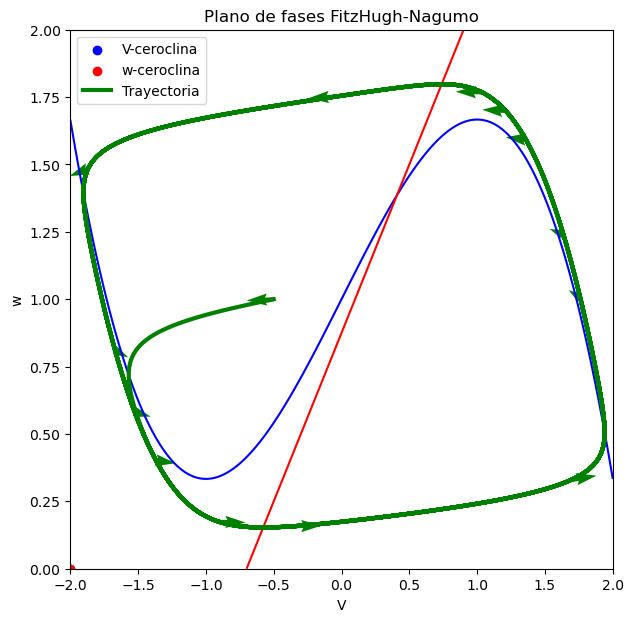

In [4]:
beta = 1.0
I1 = 1.0
a = 0.7
b = 0.8
tau = 12.5

### Campo vectorial

# Campo vectorial

def FHN(V,w):
    dV = beta*V-V**3/3-w+I1
    dw = 1/tau*(V-b*w+a)
    return [dV,dw]

# fsolve

def FHN_sol(u):
    V, w = u
    dV = beta*V-V**3/3-w+I1
    dw = 1/tau*(V-b*w+a)
    return [dV,dw]

# odeint

def FHN_int(u,t):
    V, w = u
    return FHN(V,w)

# Ceroclinas

def FHN_vnul(v,w):
    return FHN(v,w)[0]

def FHN_wnul(v,w):
    return FHN(v,w)[1]

v, w = meshgrid(linspace(-2,2,801), linspace(0,2,801))
vnul = FHN_vnul(v,w)
wnul = FHN_wnul(v,w)

fig, ax = plt.subplots(figsize=(7,7))
ax.contour(v, w, vnul, [0.0], colors = 'blue')
ax.contour(v, w, wnul, [0.0], colors = 'red')
ax.scatter([-2],[0],color = 'blue', label = 'V-ceroclina')
ax.scatter([-2],[0],color = 'red', label = 'w-ceroclina')
ax.set_title('Plano de fases FitzHugh-Nagumo')

V0 = -0.5
w0 = 1.0

## Otra condición inicial

# V0 = 0.4
# w0 = 1.35

u0 = [V0,w0]

T = linspace(0,200,20001)
I = linspace(0,len(T)-1,15)

U = odeint(FHN_int,u0,T)
V = U[:,0]
W = U[:,1]
ax.plot(V,W,color='green',linewidth=3.0,label='Trayectoria')

for k in range(len(I)-1):
    i = int(I[k])
    V1t = V[i]
    W1t = W[i]
    u1t, v1t = [FHN_vnul(V1t,W1t),FHN_wnul(V1t,W1t)]
    if norm([u1t,v1t])>0.01:
        u1t = u1t/norm([u1t,v1t])
        v1t = v1t/norm([u1t,v1t])
        p = plt.quiver([V1t],[W1t],[u1t],[v1t],color='green',scale_units='x',scale=5.0)

ax.legend()
ax.set_xlabel('V')
ax.set_ylabel('w')

In [ ]:
root = fsolve(FHN_sol,[0.0,1.25])
v0, w0 = root
[v0,w0]

In [ ]:
def FHN_jacob(V,w):

    return np.array([[beta-V**2,-1],[1/tau,-b/tau]])

In [ ]:
J0 = FHN_jacob(v0,w0)
eig(J0)[0]

Text(0, 0.5, 'w')

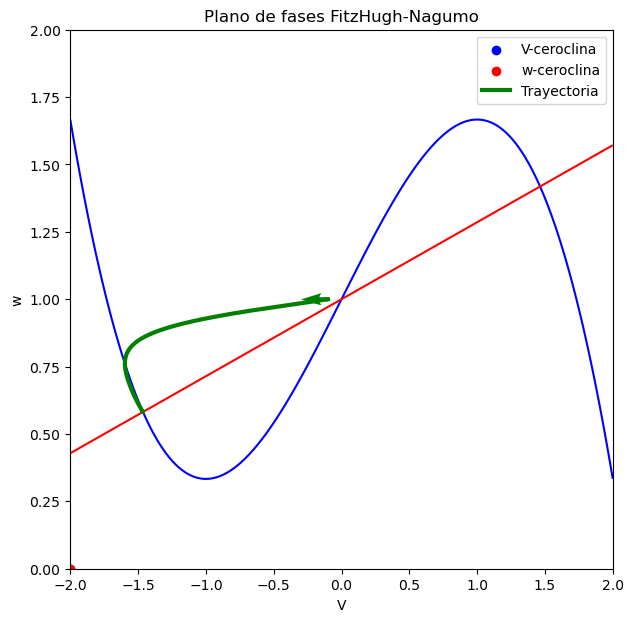

In [3]:
beta = 1.0
I1 = 1.0
a = 3.5
b = 3.5
tau = 12.5

### Campo vectorial

def FHN(V,w):
    dV = beta*V-V**3/3-w+I1
    dw = 1/tau*(V-b*w+a)
    return [dV,dw]

def FHN_sol(u):
    V, w = u
    dV = beta*V-V**3/3-w+I1
    dw = 1/tau*(V-b*w+a)
    return [dV,dw]

def FHN_int(u,t):
    V, w = u
    return FHN(V,w)

def FHN_vnul(v,w):
    return FHN(v,w)[0]

def FHN_wnul(v,w):
    return FHN(v,w)[1]

v, w = meshgrid(linspace(-2,2,801), linspace(0,2,801))
vnul = FHN_vnul(v,w)
wnul = FHN_wnul(v,w)

fig, ax = plt.subplots(figsize=(7,7))
ax.contour(v, w, vnul, [0.0], colors = 'blue')
ax.contour(v, w, wnul, [0.0], colors = 'red')
ax.scatter([-2],[0],color = 'blue', label = 'V-ceroclina')
ax.scatter([-2],[0],color = 'red', label = 'w-ceroclina')
ax.set_title('Plano de fases FitzHugh-Nagumo')

# V0 = -0.5
# w0 = 1.0

## Otra condición inicial

V0 = -0.1
w0 = 1.0

u0 = [V0,w0]

T = linspace(0,200,20001)
I = linspace(0,len(T)-1,15)

U = odeint(FHN_int,u0,T)
V = U[:,0]
W = U[:,1]
ax.plot(V,W,color='green',linewidth=3.0,label='Trayectoria')

for k in range(len(I)-1):
    i = int(I[k])
    V1t = V[i]
    W1t = W[i]
    u1t, v1t = [FHN_vnul(V1t,W1t),FHN_wnul(V1t,W1t)]
    if norm([u1t,v1t])>0.01:
        u1t = u1t/norm([u1t,v1t])
        v1t = v1t/norm([u1t,v1t])
        p = plt.quiver([V1t],[W1t],[u1t],[v1t],color='green',scale_units='x',scale=5.0)

ax.legend()
ax.set_xlabel('V')
ax.set_ylabel('w')

In [ ]:
root = fsolve(FHN_sol,[-1.5,0.5])
v0, w0 = root

root = fsolve(FHN_sol,[0.0,1.0])
v1, w1 = root

root = fsolve(FHN_sol,[1.5,1.25])
v2, w2 = root

# [v0,w0]
# [v1,w1]
[v2,w2]

In [ ]:
def FHN_jacob(V,w):

    return np.array([[beta-V**2,-1],[1/tau,-b/tau]])

In [ ]:
J0 = FHN_jacob(v0,w0)
J1 = FHN_jacob(v1,w1)
J2 = FHN_jacob(v2,w2)

# eig(J0)[0]
eig(J1)[0]
# eig(J2)[0]

[Regresar](#intro)

### Modelos compartamentales en Epidemiología

Para estudiar el avance de una enfermedad en términos poblacionales, en Epidemiología se suele trabajar con modelos *compartamentales*, en los que se definen subpoblaciones (susceptible, infectada, etc.) que interactúan entre sí, manteniendo constante un tamaño total. Un ejemplo es el modelo SIRS, en donde se trabaja con una población susceptible $S$, una población infectada $I$, y una población recuperada $R$. Una versión simplificada de este modelo se define a continuación, 

$$\begin{align*}
\dfrac{\mathrm{d}S}{\mathrm{d}t}&=\alpha N_0-\alpha S-\alpha I-\beta SI,\\
\dfrac{\mathrm{d}I}{\mathrm{d}t}&=\beta SI-\alpha I,
\end{align*}$$

donde $N_0$ es la población total, $\alpha$ es una tasa de recuperación, $\beta$ es una tasa de contagio. Definimos $R=N_0-S-I$ como la población recuperada.

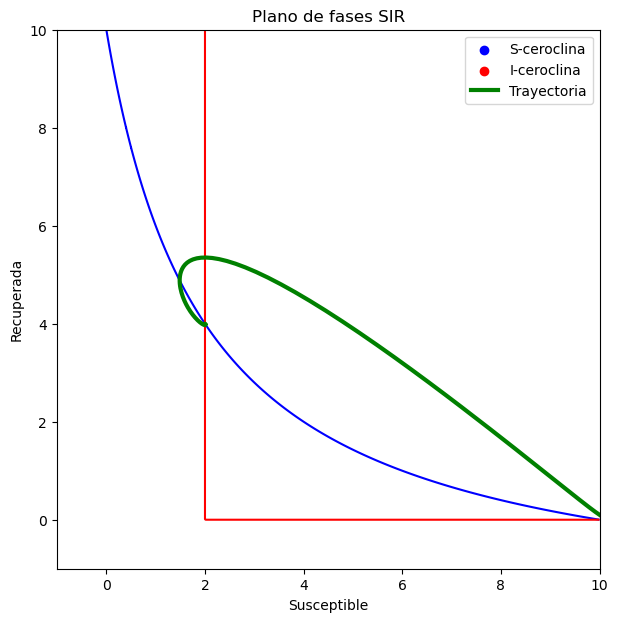

In [5]:
def SIR_int(u,t):

    S, I = u
    dS = 40-4*S-4*I-2*S*I
    dI = 2*S*I-4*I

    return [dS,dI]

def SIR(S,I):
    
    dS = 40-4*S-4*I-2*S*I
    dI = 2*S*I-4*I

    return [dS,dI]

def SIR_sol(u):
    S, I = u
    return SIR(S,I)

def SIR_snul(s,i):
    return SIR(s,i)[0]

def SIR_inul(v,w):
    return SIR(s,i)[1]

s, i = meshgrid(linspace(0,10,801), linspace(0,10,801))
snul = SIR_snul(s,i)
inul = SIR_inul(s,i)

fig, ax = plt.subplots(figsize=(7,7))
ax.contour(s, i, snul, [0.0], colors = 'blue')
ax.contour(s, i, inul, [0.0], colors = 'red')
ax.scatter([-2],[0],color = 'blue', label = 'S-ceroclina')
ax.scatter([-2],[0],color = 'red', label = 'I-ceroclina')
ax.set_title('Plano de fases SIR')

V0 = 10.0
w0 = 0.1

## Otra condición inicial

# V0 = 0.0
# w0 = 1.2

u0 = [V0,w0]

T = linspace(0,200,20001)
I = linspace(0,len(T)-1,15)

U = odeint(SIR_int,u0,T)
S = U[:,0]
I = U[:,1]
ax.plot(S,I,color='green',linewidth=3.0,label='Trayectoria')

# for k in range(len(I)-1):
#     i = int(I[k])
#     s1t = S[i]
#     i1t = I[i]
#     u1t = SIR(s1t,i1t)[0]
#     v1t = SIR(s1t,i1t)[1]
#     # , v1t = [SIR_snul(V1t,W1t),SIR_inul(V1t,W1t)]
#     if norm([u1t,v1t])>0.01:
#         u1t = u1t/norm([u1t,v1t])
#         v1t = v1t/norm([u1t,v1t])
#         p = plt.quiver([V1t],[W1t],[u1t],[v1t],color='green',scale_units='x',scale=5.0)

ax.set_xlim(-1,10)
ax.set_ylim(-1,10)
ax.set_xlabel('Susceptible')
ax.set_ylabel('Recuperada')
ax.legend()

Notamos dos puntos de equilibrio, $(S_0,I_0)=(2,4)$, y $(S_1,I_1)=(10,0)$. Con las simulaciones podemos convencernos de que el primero es un atractor, y el segundo es una silla. Para comprobarlo, calculamos la jacobiana del sistema y evaluamos en cada equilibrio. 

In [7]:
def SIR_jac(s,i):

    return np.array([[-4-2*i,-4-2*s],[2*i,2*s-4]])

J0 = SIR_jac(2,4)
J1 = SIR_jac(10,0)

# Foco atractor
# eig(J0)[0]

# Silla
eig(J1)[0]

array([-4., 16.])

El hecho de que uno de los dos equilibrios sea atractor, y que el otro repela en al menos una dirección, indica que uno de estos estados es más *probable* de observar en un experimento. Por ejemplo, eligiendo algunas condiciones iniciales al azar, notaremos que con alta probabilidad, éstas convergen al equilibrio $(2,4)$. En particular, la población recuperada tiende al valor $R=4$ casi seguramente.

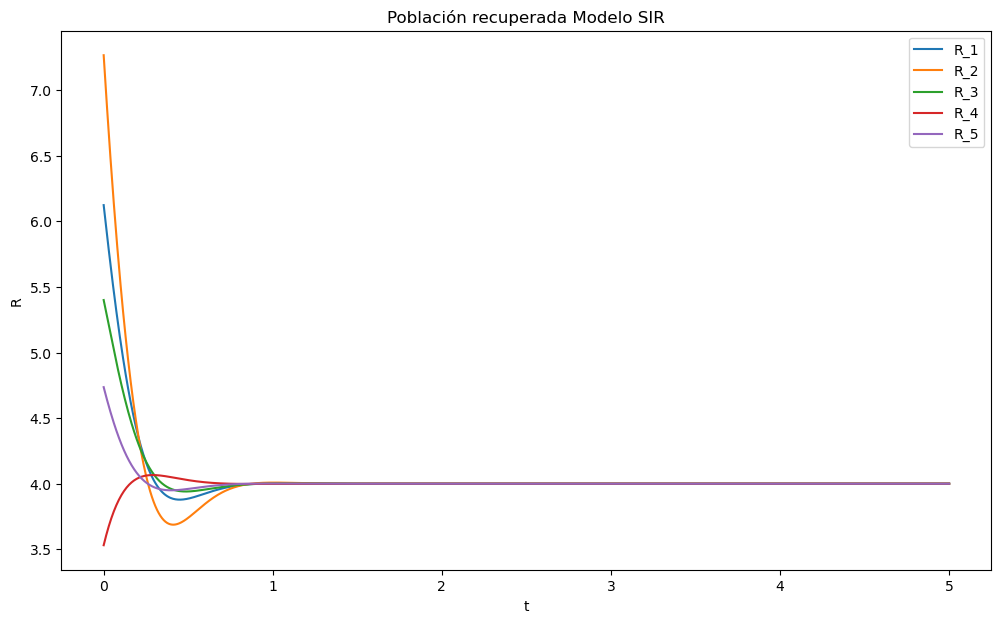

In [8]:
t = linspace(0,5,1001)
p = plt.figure(figsize=(12,7))

for k in range(5):

    S0 = uniform(0,5)
    I0 = uniform(0,5)

    u0 = [S0,I0]

    U = odeint(SIR_int,u0,t)
    S = U[:,0]
    I = U[:,1]
    R = 10-S-I

    p = plt.plot(t,R,label='R_'+str(k+1))

p = plt.legend()
p = plt.title('Población recuperada Modelo SIR')
p = plt.xlabel('t')
p = plt.ylabel('R')

### Modelos de tasa de disparo

Describir simultáneamente la evolución de dos o más neuronas que interactúan suele ser una tarea complicada. Una propuesta para este problema es ignorar el estado específico de cada neurona (i.e. potencial de membrana, compuertas de activación, etc.), y enfocarse en su actividad, definida como la frecuencia de espigueo. A esto le conocemos como un *modelo de tasa de disparo (firing-rate models)*.

Un ejemplo de este esquema mide la respuesta de dos neuronas idénticas en el lóbulo frontal de un simio frente a una discriminación entre dos señales luminosas (memoria a corto plazo). Estas neuronas se excitan mutuamente mediante el sistema

\begin{align*}
\dfrac{\mathrm{d}E_1}{\mathrm{d}t}&=\dfrac{1}{\tau}\left(-E_1+\dfrac{100(3E_2)^2}{120^2+(3E_2)^2}\right),\\
\dfrac{\mathrm{d}E_2}{\mathrm{d}t}&=\dfrac{1}{\tau}\left(-E_2+\dfrac{100(3E_1)^2}{120^2+(3E_1)^2}\right).
\end{align*}

Decimos que la función de interacción $f(e)=\tfrac{100(3e)^2}{120^2+(3e)^2}$ es del tipo **Naka-Rushton**, y dibuja una curva con forma de *s* creciente acotada entre 0 y 100 para $e\geqslant0$. En el sistema anterior las variables $E_1$ y $E_2$ denotan la *tasa de actividad* de las neuronas 1 y 2, respectivamente, por lo que valores altos de cada variable indica un número alto de potenciales de acción por unidad de tiempo. 

Analizaremos este modelo mediante su plano de fases, clasificando, cuando encontremos, los puntos de equilibrio mediante su matriz jacobiana.

Text(0.5, 1.0, 'Plano de fases actividad retinal')

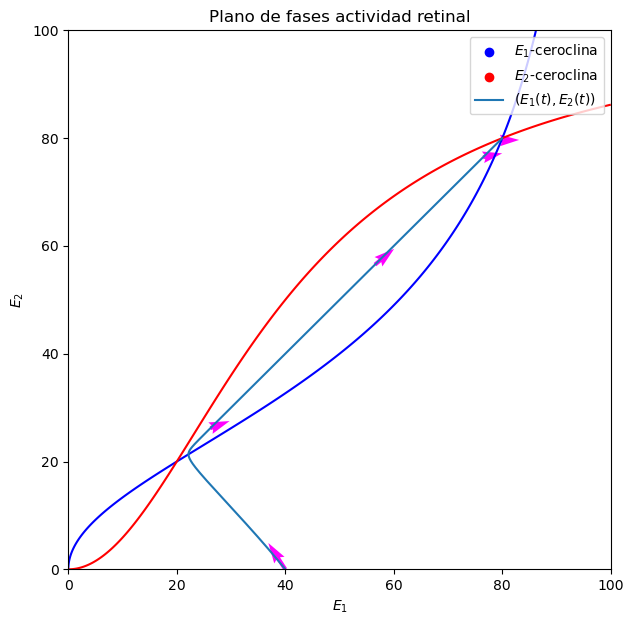

In [12]:
tau = 20.0

def nr(e):
    return 100*(3*e)**2/(120**2+(3*e)**2)

def dnr(e):

    return 100*120**2*18*e/(120**2+(3*e)**2)**2

def rate(E1,E2):
    dE1 = 1/tau*(-E1+nr(E2))
    dE2 = 1/tau*(-E2+nr(E1))
    return [dE1,dE2]

def rate_e1nul(E1,E2):

    return rate(E1,E2)[0]

def rate_e2nul(E1,E2):

    return rate(E1,E2)[1]

def rate_int(u,t):
    E1, E2 = u
    return rate(E1,E2)

e1, e2 = meshgrid(linspace(0,100,801), linspace(0,100,801))
e1nul = rate_e1nul(e1,e2)
e2nul = rate_e2nul(e1,e2)

fig, ax = plt.subplots(figsize=(7,7))
ax.contour(e1, e2, e1nul, [0.0], colors = 'blue')
ax.contour(e1, e2, e2nul, [0.0], colors = 'red')
ax.scatter([-2],[0],color = 'blue', label = '$E_1$-ceroclina')
ax.scatter([-2],[0],color = 'red', label = '$E_2$-ceroclina')

# e10 = 0.0
# e20 = 40.0

# Otra condición inicial

e10 = 40.0
e20 = 0.0

# Otra otra condición inicial

# e10 = 20.1
# e20 = 19.9

u0 = [e10,e20]

T = linspace(0,1000,100001)
I = linspace(0,len(T),15)

U0 = odeint(rate_int,u0,T)
E10 = U0[:,0]
E20 = U0[:,1]

ax.plot(E10,E20,label='$(E_1(t),E_2(t))$')
for k in range(len(I)-1):
    i = int(I[k])
    Vt = E10[i]
    Wt = E20[i]
    ut, vt = rate(Vt,Wt)
    if norm([ut,vt])>0.01:
        ut = ut/norm([ut,vt])
        vt = vt/norm([ut,vt])
        p = plt.quiver([Vt],[Wt],[ut],[vt],color='magenta',scale_units='x',scale=0.2)

ax.legend()
ax.set_xlabel('$E_1$')
ax.set_ylabel('$E_2$')
ax.set_ylim(0.0,100.0)
ax.set_xlim(0.0,100.0)
ax.set_title('Plano de fases actividad retinal')

Observamos tres equilibrios (que pudimos haber obtenido a mano): $(0,0)$, $(20,20)$, $(80,80)$. Las simulaciones sugieren que el primero y el tercero son atractores, y que el segundo es silla. Lo comprobamos mediante la matriz jacobiana.

In [15]:
def rate_jac(e1,e2):

    return np.array([[-1/tau,1/tau*dnr(e2)],[1/tau*dnr(e1),-1/tau]])

J0 = rate_jac(0,0)
J1 = rate_jac(20,20)
J2 = rate_jac(80,80)

J2

# eig(J0)[0]
# eig(J1)[0]
eig(J2)[0]

array([-0.03, -0.07])

Intepretamos los resultados de la siguiente manera: la excitación mutua entre ambas neuronas produce un estado simétrico en el que, o ambas convergen a una tasa alta de actividad ($E_1=E_2=80$), o ambas convergen al reposo ($E_1=E_2=0.0$). El punto silla de en medio funciona como una separatriz entre ambos estados.

[Regresar](#intro)

### Oscilador de Stuart-Landau

Como último ejemplo, veremos un modelo que es frecuentemente utilizado para describir ciertos comportamientos periódicos. El *oscilador de Stuart-Landau* está definido por las ecuaciones 

$$\begin{align*}
\dot{x}&=-y+x(1-x^2-y^2),\\
\dot{y}&=x+y(1-x^2-y^2),
\end{align*}$$

donde cada variable representa las coordenadas de una partícula en el plano. Como notaremos, las oscilaciones producidas por este modelo varían cualitativamente de las vistas en Lotka-Volterra.

Text(0.5, 1.0, 'Plano de fases Stuart-Landau')

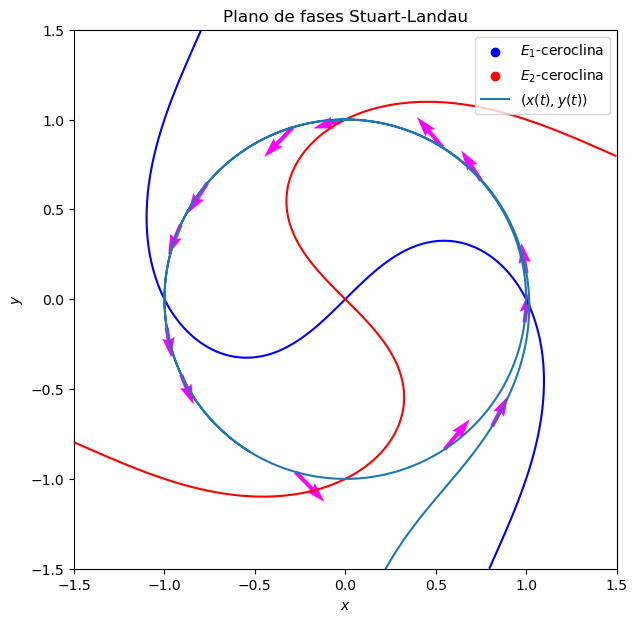

In [19]:
def slo(x,y):
    dx = -y+x*(1-x**2-y**2)
    dy = x+y*(1-x**2-y**2)
    return [dx,dy]

def slo_xnul(x,y):

    return slo(x,y)[0]

def slo_ynul(x,y):

    return slo(x,y)[1]

def slo_int(u,t):
    x, y = u
    return slo(x,y)

x, y = meshgrid(linspace(-1.5,1.5,801), linspace(-1.5,1.5,801))
xnul = slo_xnul(x,y)
ynul = slo_ynul(x,y)

fig, ax = plt.subplots(figsize=(7,7))
ax.contour(x, y, xnul, [0.0], colors = 'blue')
ax.contour(x, y, ynul, [0.0], colors = 'red')
ax.scatter([-2],[0],color = 'blue', label = '$E_1$-ceroclina')
ax.scatter([-2],[0],color = 'red', label = '$E_2$-ceroclina')

x0 = 0.01
y0 = -2.01

u0 = [x0,y0]

T = linspace(0,12.0,1201)
I = linspace(0,len(T),15)

U0 = odeint(slo_int,u0,T)
X0 = U0[:,0]
Y0 = U0[:,1]

ax.plot(X0,Y0,label='$(x(t),y(t))$')
for k in range(len(I)-1):
    i = int(I[k])
    xt = X0[i]
    yt = Y0[i]
    ut, vt = slo(xt,yt)
    if norm([ut,vt])>0.01:
        ut = ut/(30*norm([ut,vt]))
        vt = vt/(30*norm([ut,vt]))
        p = plt.quiver([xt],[yt],[ut],[vt],color='magenta',scale_units='x',scale=0.2)

ax.legend()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_ylim(-1.5,1.5)
ax.set_xlim(-1.5,1.5)
ax.set_title('Plano de fases Stuart-Landau')

Es fácil convencerse de que el equilibrio en el origen es un foco repulsor (pero hay que hacerlo). Lo interesante de este sistema es que cualquier solución distinta del equilibrio tenderá a la circunferencia de radio 1, por lo que todas las trazas temporales son *eventualmente* periódicas del mismo período y amplitud (pero cada una con su propia fase). Esto es un comportamiento oscilatorio distinto al del modelo Lotka-Volterra, donde cada órbita era cerrada pero de amplitudes distintas.

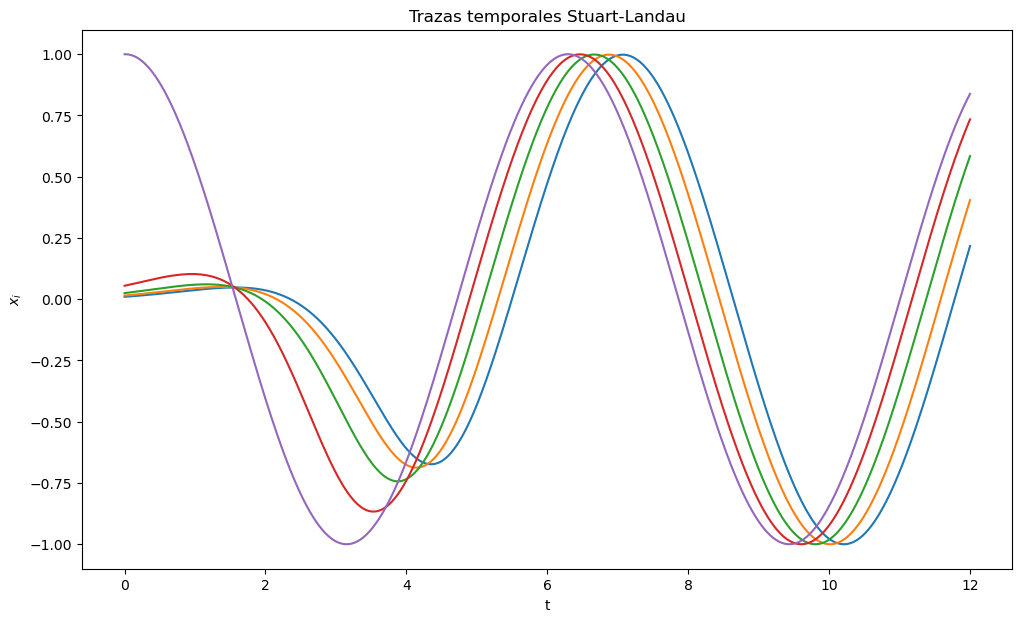

In [18]:
x0 = 0.01
x1 = 0.015
x2 = 0.025
x3 = 0.055
x4 = 1.0

u0 = [x0,y0]
u1 = [x1,y0]
u2 = [x2,y0]
u3 = [x3,y0]
u4 = [x4,y0]

U0 = odeint(slo_int,u0,T)
X0 = U0[:,0]

U1 = odeint(slo_int,u1,T)
X1 = U1[:,0]

U2 = odeint(slo_int,u2,T)
X2 = U2[:,0]

U3 = odeint(slo_int,u3,T)
X3 = U3[:,0]

U4 = odeint(slo_int,u4,T)
X4 = U4[:,0]

p = plt.figure(figsize=(12,7))

p = plt.plot(T,X0)
p = plt.plot(T,X1)
p = plt.plot(T,X2)
p = plt.plot(T,X3)
p = plt.plot(T,X4)

p = plt.title('Trazas temporales Stuart-Landau')
p = plt.xlabel('t')
p = plt.ylabel('$x_i$')

[Regresar](#intro)